In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spike_psvae.waveform_utils import make_channel_index, make_contiguous_channel_index
from spike_psvae import denoise
from spike_psvae.denoise import SingleChanDenoiser
from pathlib import Path
import torch
from scipy.stats import zscore
import gc

In [134]:
spikes_info_dir = '/moto/stats/users/hy2562/projects/ephys_atlas/benchmark_snippets_example/1e104bf4-7a24-4624-a5b2-c2c8289c0de7/T00500/spikes.pqt'
ap_dir = '/moto/stats/users/hy2562/projects/ephys_atlas/benchmark_snippets_example/1e104bf4-7a24-4624-a5b2-c2c8289c0de7/T00500/ap.npy'

In [135]:
df_spikes = pd.read_parquet(spikes_info_dir)
time_points = np.int32(df_spikes['sample'].values)
maxchans = np.int32(df_spikes['trace'].values)

In [136]:
geom_dir = '/moto/stats/users/hy2562/projects/ephys_atlas/benchmark_snippets_example/1e104bf4-7a24-4624-a5b2-c2c8289c0de7/T00500/geom.npy'
geom = np.load(geom_dir)
extract_box_radius = 200
box_norm_p = 2
extract_channel_index = make_channel_index(
            geom, extract_box_radius, distance_order=False, p=box_norm_p
        )

In [137]:
device = 'cuda'
ci_graph_on_probe, maxCH_neighbor = denoise.make_ci_graph(extract_channel_index, geom, device)
ci_graph_all_maxCH_uniq = denoise.make_ci_graph_all_maxCH(ci_graph_on_probe, maxCH_neighbor, device)
Denoiser = SingleChanDenoiser().load().to(device)

In [138]:
ap = np.load(ap_dir).T
ap = np.float32(ap)
ap_zscored = zscore(ap)
wfs_to_denoise = np.full((len(time_points), 121, 40), np.nan)

s = time_points - 42
e = time_points + 79

for i in range(len(time_points)):
    start_frame = s[i]
    end_frame = e[i]
    ci = extract_channel_index[maxchans[i]]
    ci_not_nan = np.squeeze(np.where(ci < 384))
    
    wfs_to_denoise[i, :, ci_not_nan] = ap_zscored[start_frame:end_frame,:][:,ci[ci_not_nan]].T

In [158]:
import time

In [159]:
s = time.time()
batch_size = 1000
batch_n = len(time_points)//batch_size
batch_s = 0

maxchans = torch.as_tensor(maxchans, device=device)


denoised_wfs = np.full(np.shape(wfs_to_denoise), np.nan)
for i in range(batch_n):
    del(waveforms_denoise)
    gc.collect()
    torch.cuda.empty_cache()
    
    batch_e = batch_s + batch_size
    
    batch_to_denoise = torch.as_tensor(wfs_to_denoise[batch_s:batch_e, :, :], device=device, dtype=torch.float)

    waveforms_denoise = denoise.multichan_phase_shift_denoise_preshift(batch_to_denoise, ci_graph_all_maxCH_uniq, maxCH_neighbor, Denoiser, maxchans[batch_s:batch_e], device)
    denoised_wfs[batch_s:batch_e, :, :] = waveforms_denoise.detach().cpu().numpy()
    batch_s  = batch_e


batch_to_denoise = torch.as_tensor(wfs_to_denoise[batch_s:, :, :], device=device, dtype=torch.float)

waveforms_denoise = denoise.multichan_phase_shift_denoise_preshift(batch_to_denoise, ci_graph_all_maxCH_uniq, maxCH_neighbor, Denoiser, maxchans[batch_s:], device)
denoised_wfs[batch_s:, :, :] = waveforms_denoise.detach().cpu().numpy()

print(time.time() - s)

15.726969242095947


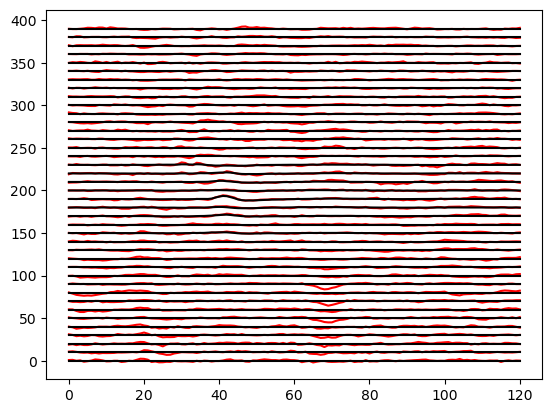

In [156]:
i = 999

bias = np.arange(40)[:, None].repeat(121, 1)
plt.plot(wfs_to_denoise[i, :, :]+bias.T*10, c = 'r');
plt.plot(denoised_wfs[i, :, :]+bias.T*10, c = 'k');